In [1]:
import numpy as np 
import pandas as pd

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,KFold
from lightgbm import LGBMRegressor
import lightgbm as lgb

from sklearn.metrics import root_mean_squared_error
import warnings
import optuna
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [4]:
train_d = pd.read_csv("train.csv")
test_d = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")


In [5]:
train_d.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [6]:
test_d.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [7]:
train_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [8]:
train_d.isnull().sum()

id                  0
age                 0
gender              0
course              0
study_hours         0
class_attendance    0
internet_access     0
sleep_hours         0
sleep_quality       0
study_method        0
facility_rating     0
exam_difficulty     0
exam_score          0
dtype: int64

In [9]:
train_d.shape

(630000, 13)

In [10]:
test_d.shape

(270000, 12)

In [11]:
cat_col = train_d.select_dtypes('object').columns
num_col = train_d.select_dtypes(include = ['int64','float64']).columns
print("Categorical Columns Are:")
for i,name in enumerate(cat_col,1):
    print(i,name)
print("\n")
print("Numerical Columns Are:")
for i,name in enumerate(num_col,1):
    print(i,name)

Categorical Columns Are:
1 gender
2 course
3 internet_access
4 sleep_quality
5 study_method
6 facility_rating
7 exam_difficulty


Numerical Columns Are:
1 id
2 age
3 study_hours
4 class_attendance
5 sleep_hours
6 exam_score


In [12]:
print("Printing Unique Values Of All Columns")
for col in train_d:
    print("-"*60)
    unq = train_d[col].unique()
    if len(unq) < 15:
        print(f"{col} : {unq}\n")
    else:
        print(f"{col} : {unq[:5]} .... {col} Have So much Unique Values \n")

Printing Unique Values Of All Columns
------------------------------------------------------------
id : [0 1 2 3 4] .... id Have So much Unique Values 

------------------------------------------------------------
age : [21 18 20 19 23 24 22 17]

------------------------------------------------------------
gender : ['female' 'other' 'male']

------------------------------------------------------------
course : ['b.sc' 'diploma' 'bca' 'b.com' 'ba' 'bba' 'b.tech']

------------------------------------------------------------
study_hours : [7.91 4.95 4.68 2.   7.65] .... study_hours Have So much Unique Values 

------------------------------------------------------------
class_attendance : [98.8 94.8 92.6 49.5 86.9] .... class_attendance Have So much Unique Values 

------------------------------------------------------------
internet_access : ['no' 'yes']

------------------------------------------------------------
sleep_hours : [4.9 4.7 5.8 8.3 9.6] .... sleep_hours Have So much Unique

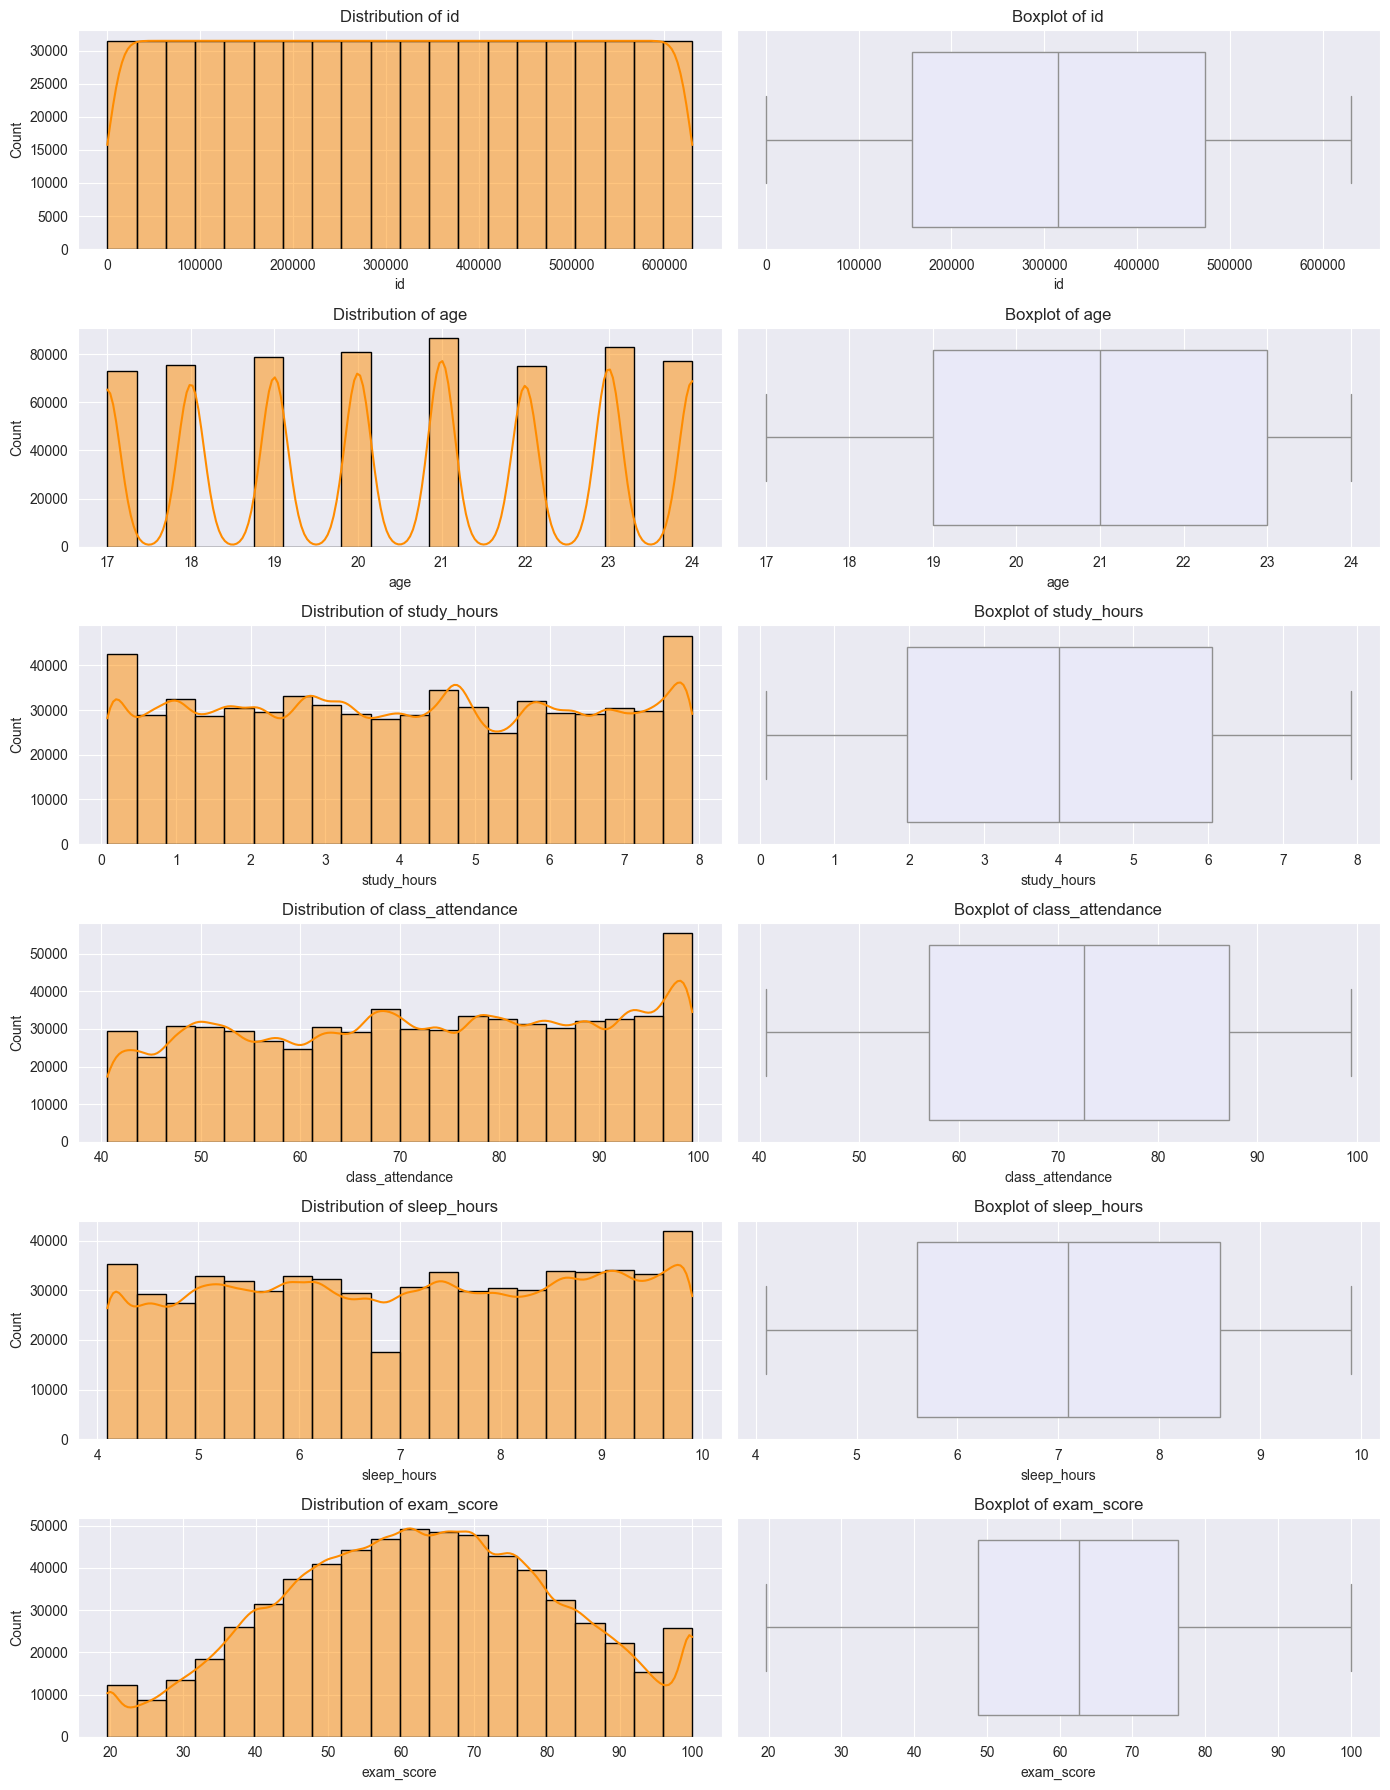

In [13]:
sns.set_style('darkgrid')
plt.figure(figsize = (14,len(num_col)*3))

for idx,col in enumerate(num_col,1):
    plt.subplot(len(num_col),2,2*idx-1)
    sns.histplot(train_d[col],kde = True,bins = 20,color = 'darkorange',edgecolor ='black')
    plt.title(f"Distribution of {col}")

    plt.subplot(len(num_col),2,2*idx)
    sns.boxplot(x = train_d[col],color = 'lavender')
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

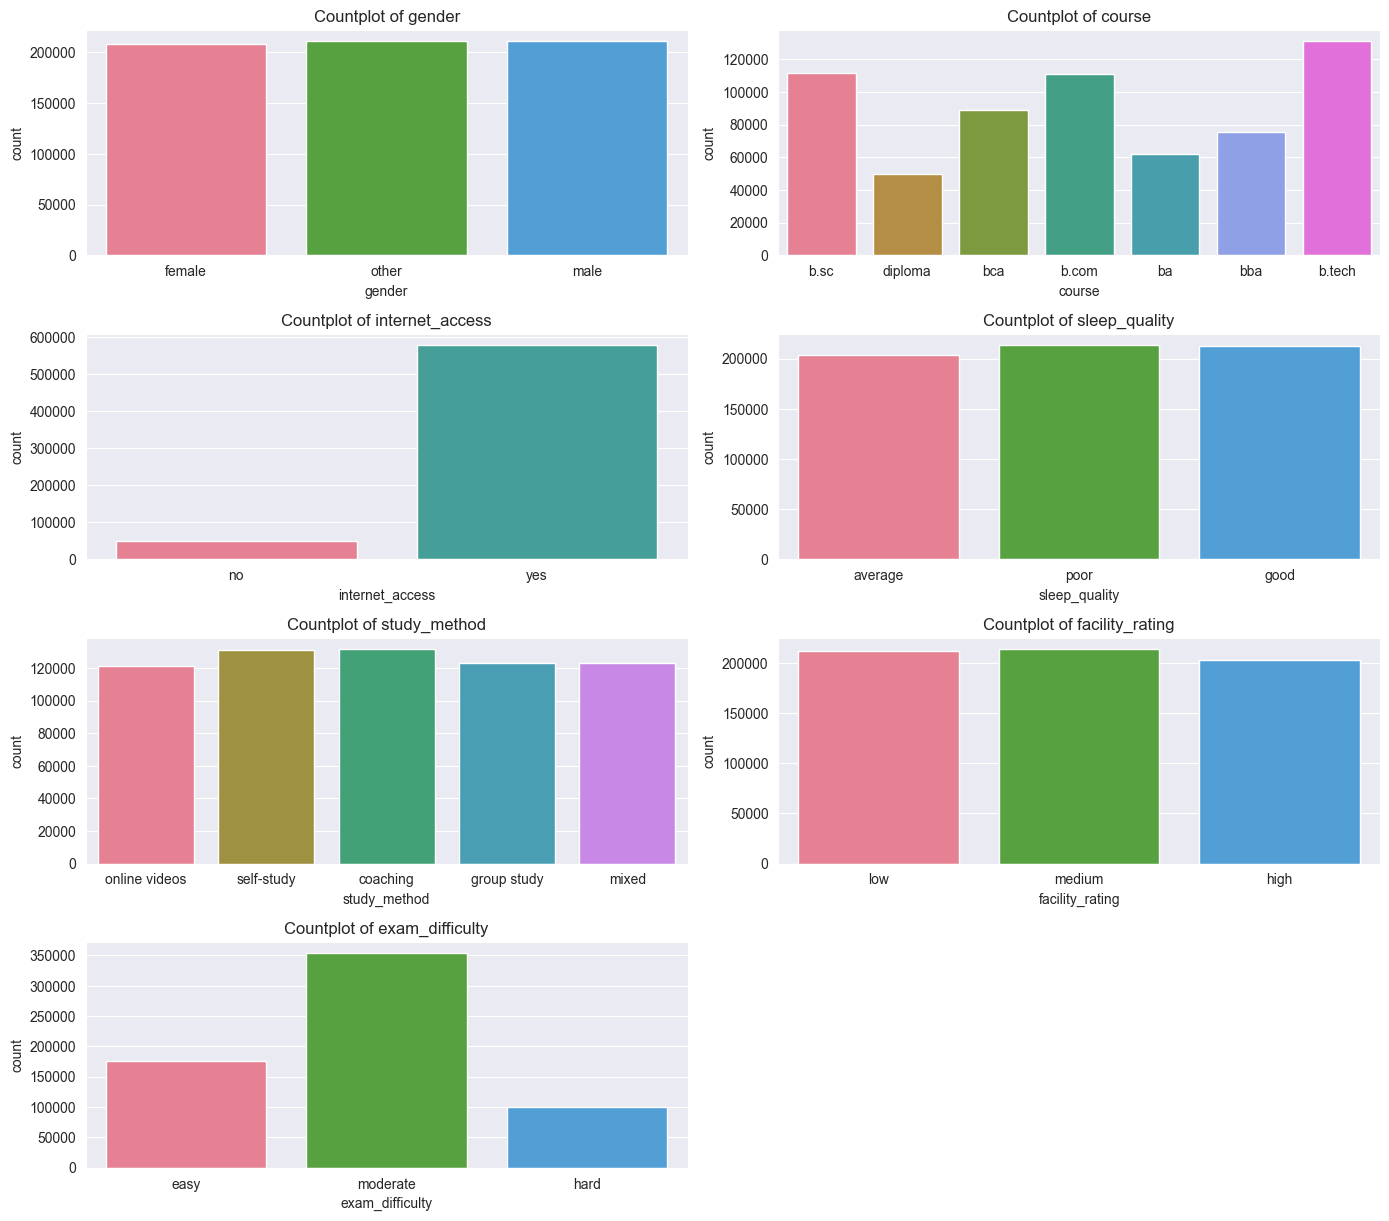

In [14]:
plt.figure(figsize = (14,len(cat_col)*3))

for idx,col in enumerate(cat_col,1):
    plt.subplot(len(cat_col),2,idx)
    sns.countplot(x = col,data = train_d,palette = 'husl')
    plt.title(f"Countplot of {col}")

plt.tight_layout()
plt.show()

In [15]:
def target_encoding(train, predict, n_splits=8):
    train = train.copy()
    predict = predict.copy()

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    mean_features_train = {}
    mean_features_test = {}

    # Compute global mean once
    target_global = train[target].mean()

    for col in cols:

        # K-FOLD TARGET ENCODING
        oof = np.zeros(len(train))
        for tr_idx, val_idx in kf.split(train):
            tr_fold = train.iloc[tr_idx]
            # Mean for each category in this fold
            fold_map = tr_fold.groupby(col)[target].mean()

            # Map on validation fold
            oof[val_idx] = train[col].iloc[val_idx].map(fold_map).fillna(target_global)

        mean_features_train[f"mean_{col}"] = oof

        # Apply encoding to the prediction set
        global_map = train.groupby(col)[target].mean()
        mean_features_test[f"mean_{col}"] = (
            predict[col].map(global_map).fillna(target_global)
        )


    train = pd.concat([train, pd.DataFrame(mean_features_train)], axis=1)
    predict = pd.concat([predict, pd.DataFrame(mean_features_test)], axis=1)

    return train, predict


In [16]:
target = 'exam_score'

cols = (
    train_d.drop(columns = ['id',target],errors = 'ignore')
    .columns
    .tolist()
)

train_d,test_d = target_encoding(train_d,test_d,n_splits = 10)

In [17]:
for col in cat_col:
    train_d[col] = train_d[col].astype('category')
    test_d[col] = test_d[col].astype('category')

In [18]:
train_d = train_d.drop('id',axis = 1)
test_d = test_d.drop('id',axis = 1)

In [19]:
x,y = train_d.drop('exam_score',axis = 1),train_d['exam_score']

In [20]:
def objective(trial):

    params = {
        "objective": "regression",
        "boosting_type": "gbdt",
        'device' : 'gpu',
        'n_jobs' :-1,
        "verbosity": -1,
        'max_bin':255,
        'min_data_in_bin':3,
        'metric':'rmse',
        
        "n_estimators" : trial.suggest_int("n_estimators",2000,6000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.03),
        "num_leaves": trial.suggest_int("num_leaves", 16, 256),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),

    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = []

    for tr_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(
            **params,

        )

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(100, verbose=False)],
        )
        
        
        val_preds = model.predict(X_val)
        rmse.append(root_mean_squared_error(y_val, val_preds))

    return np.mean(rmse)

In [21]:
best_params = {
    
    'n_estimators': 5913,
    'learning_rate': 0.017246545508898457,
    'num_leaves': 152,
    'max_depth': 12,
    'min_child_samples': 58,
    'bagging_freq': 6,
    'subsample': 0.947552381290211,
    'subsample_freq' : 1,
    'colsample_bytree': 0.6233069881162507,
    'lambda_l1': 3.8389492249733914,
    'lambda_l2': 3.64021453136343,
    'verbose' : -1,
    'verbosity':-1}

In [ ]:
oof_preds = np.zeros(len(train_d))
lgb_preds = np.zeros(len(test_d))
fold_rmse = []

n_splits = 5
sk = KFold(n_splits = n_splits,shuffle = True,random_state = 42)

for fold,(tr_idx,val_idx) in enumerate (sk.split(x,y),1):
    x_train,y_train = x.iloc[tr_idx], y.iloc[tr_idx]
    x_val,y_val = x.iloc[val_idx],y.iloc[val_idx]

    model = LGBMRegressor(
        **best_params,
        objective = 'regression',
        boosting_type = 'gbdt',
        device_type = 'gpu',
        max_bin =255,
        min_data_in_bin = 3,
        n_jobs = -1,
        random_state = 42
    )

    model.fit(
        x_train,y_train,
        eval_set = [(x_val,y_val)],
        eval_metric = "rmse",
        callbacks = [
            lgb.early_stopping(300),
            lgb.log_evaluation(500)
        
        ]
        
    )

    val_preds = model.predict(x_val)
    oof_preds[val_idx] = val_preds
    lgb_preds += model.predict(test_d)/n_splits

    rmse = root_mean_squared_error(y_val,val_preds)
    fold_rmse.append(rmse)
    print(f"FOLD: {fold} RMSE : {rmse:.5f}")

overall_rmse = root_mean_squared_error(y,oof_preds)
print("FOLD RMSE: ",[round(s,4) for s in fold_rmse])
print(f"Overall RMSE: {overall_rmse:.4f}" )

Training until validation scores don't improve for 300 rounds


In [ ]:
submission['exam_score'] = lgb_preds

In [ ]:
submission.to_csv('submission.csv',index = False)

In [ ]:
submission.head()